In [9]:
pip install torch scikit-learn pandas numpy matplotlib seaborn

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.7/9.7 MB 63.5 MB/s  0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 37.7/37.7 MB 79.2 MB/s  0:00:00 83.7 MB/s eta 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4/4 [scikit-learn]0m 3/4 [scikit-learn]
Note: you may need to restart the kernel to use updated packages.


In [27]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import math
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os

✅ Successfully loaded data!
   Rows (Envs): 40960
   Columns:     4849
✅ Fixed 'gt_fric_force' column types.

--- Target Property Distributions ---


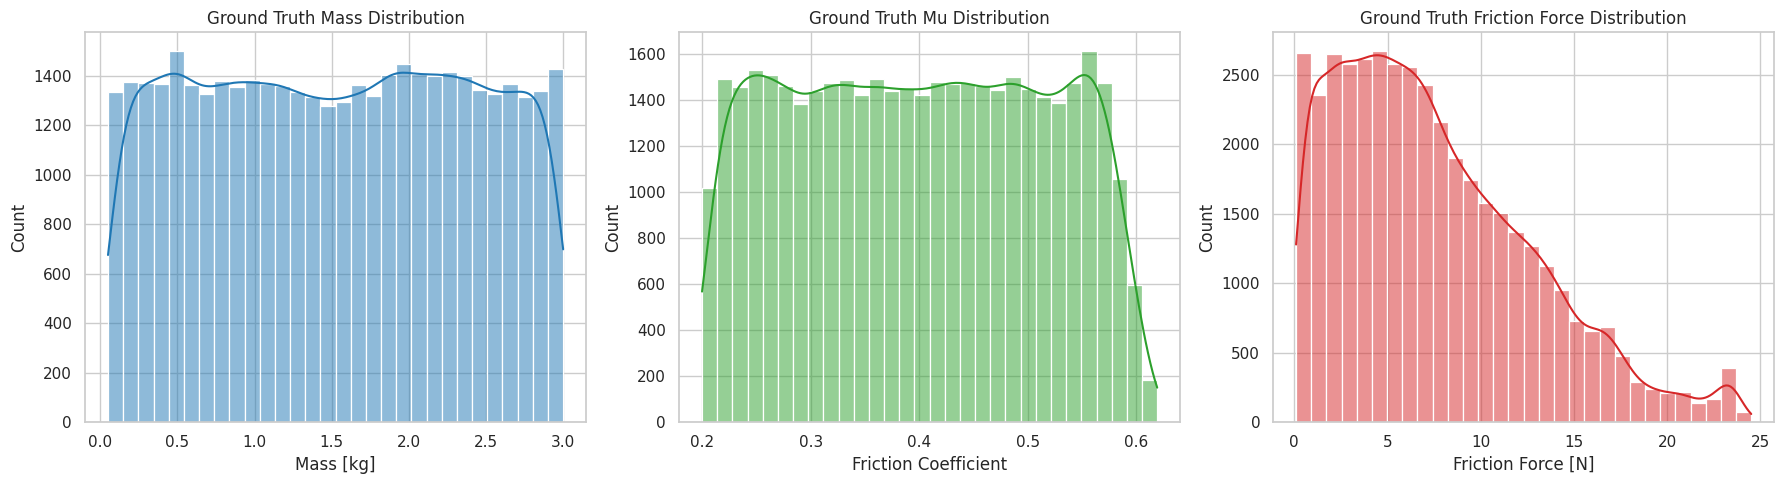


ANALYZING SAMPLE #33303
GT Mass: 2.223 kg
GT Mu:   0.297
GT Fric Force (Target): 7.355 N
Time Window: 63 -> 83


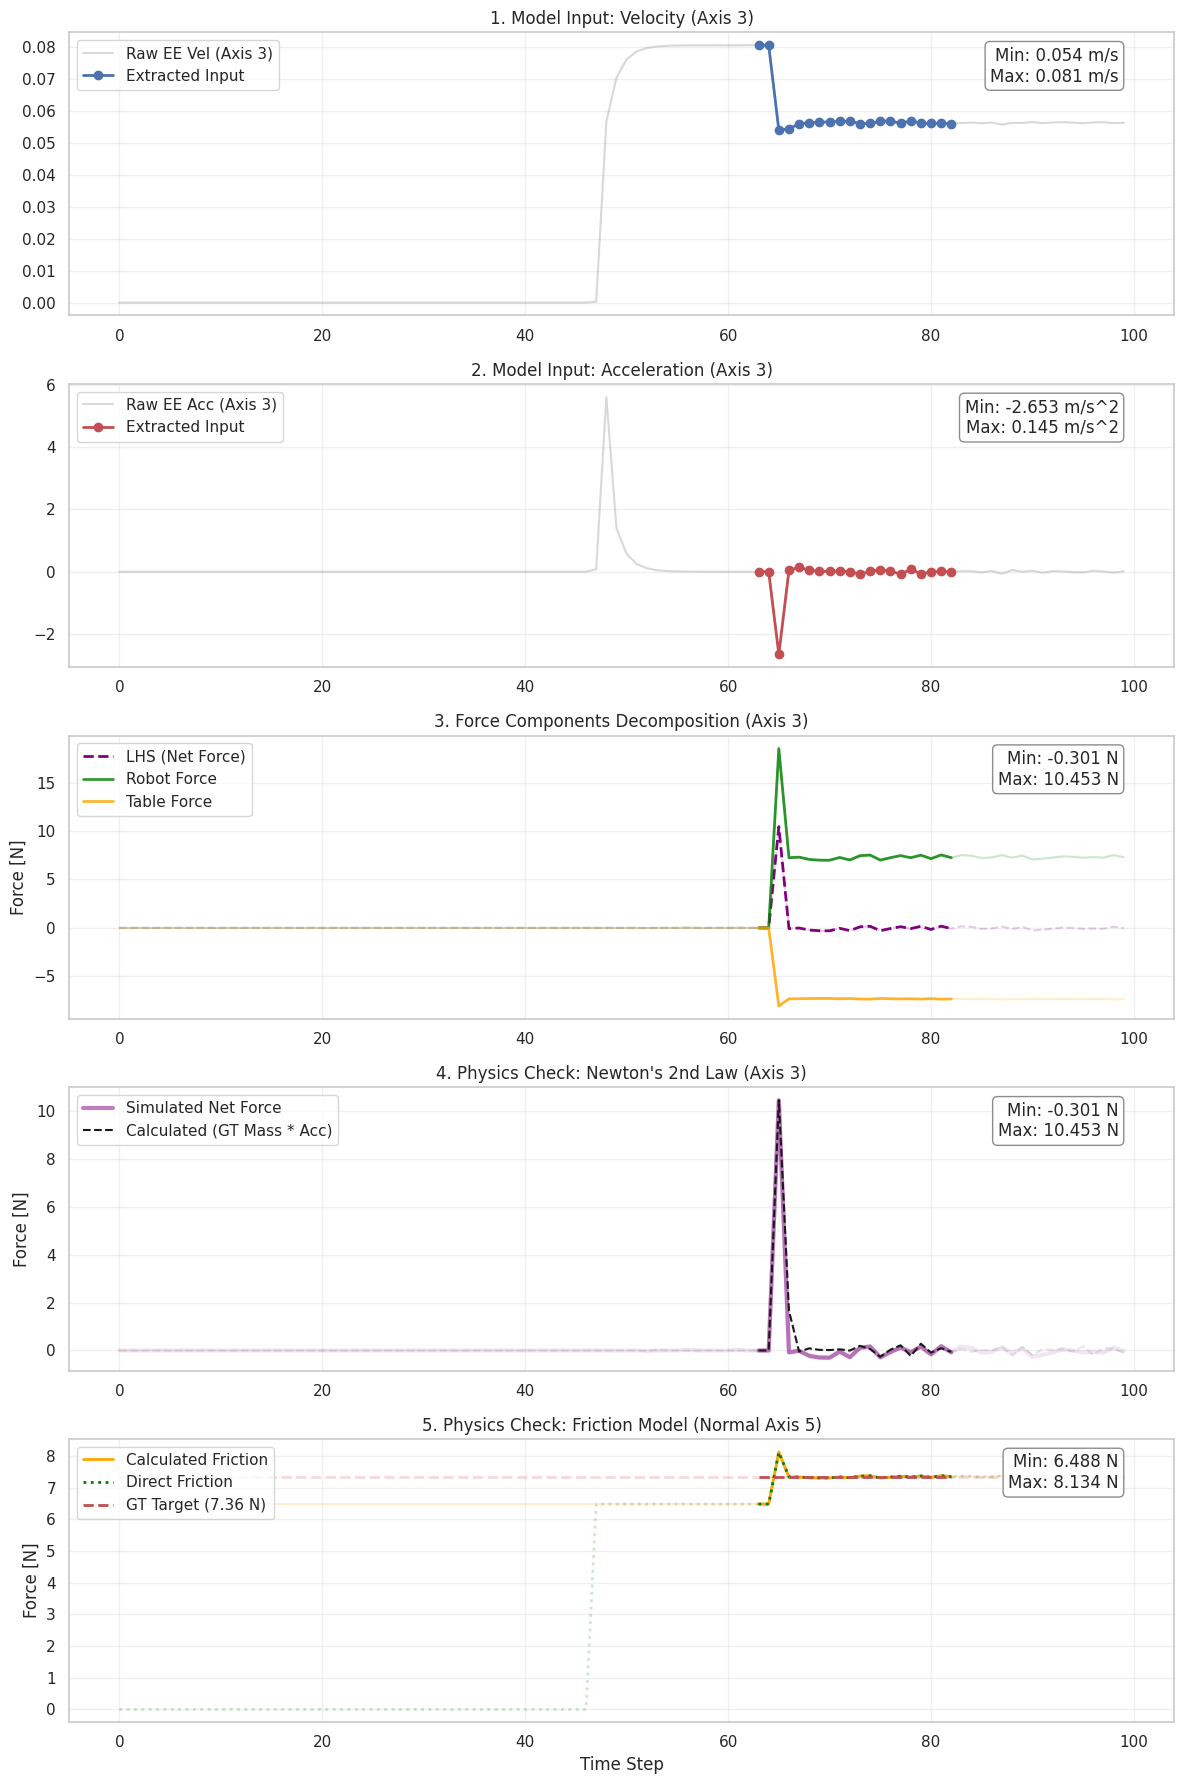

In [28]:

# ==========================================
# 1. CONFIGURATION
# ==========================================
CSV_PATH = "/home/psxkf4/IsaacLab/source/collected_data/offline_data_8192.csv" 

# Set plot style
sns.set_theme(style="whitegrid")
plt.rcParams['figure.figsize'] = (14, 6)

# ==========================================
# 2. LOAD DATA
# ==========================================
if not os.path.exists(CSV_PATH):
    print(f"❌ Error: File not found at {CSV_PATH}")
    print("Please check the path and try again.")
else:
    df = pd.read_csv(CSV_PATH)
    print(f"✅ Successfully loaded data!")
    print(f"   Rows (Envs): {df.shape[0]}")
    print(f"   Columns:     {df.shape[1]}")
    
    # Optional: Display the dataframe
    # display(df)

# --- FIX DATA TYPES ---
# The 'gt_fric_force' column might be saved as strings (e.g., "[4.23]"). 
def clean_force_col(x):
    if isinstance(x, str):
        return float(x.strip('[]'))
    return x

if 'gt_fric_force' in df.columns:
    df['gt_fric_force'] = df['gt_fric_force'].apply(clean_force_col)
    print("✅ Fixed 'gt_fric_force' column types.")

# ==========================================
# 3. HELPER FUNCTIONS
# ==========================================
def get_sequence_data(row, prefix, seq_len=100, num_axes=6):
    """Reconstructs (100, 6) array from flattened columns like 'prefix_t0_ax0'"""
    data = np.zeros((seq_len, num_axes))
    for t in range(seq_len):
        for ax in range(num_axes):
            col = f"{prefix}_t{t}_ax{ax}"
            if col in row:
                data[t, ax] = row[col]
    return data

def get_flat_window(row, prefix, window_size=10):
    """Reconstructs 1D array from columns like 'prefix_0', 'prefix_1'"""
    data = np.zeros(window_size)
    for i in range(window_size):
        col = f"{prefix}_{i}"
        if col in row:
            data[i] = row[col]
    return data

# ==========================================
# 4. DISTRIBUTION PLOTS (Targets)
# ==========================================
if 'df' in locals():
    print("\n--- Target Property Distributions ---")
    fig, axes = plt.subplots(1, 3, figsize=(18, 5))
    
    # Mass
    sns.histplot(df['gt_mass'], kde=True, ax=axes[0], color='tab:blue', bins=30)
    axes[0].set_title('Ground Truth Mass Distribution')
    axes[0].set_xlabel('Mass [kg]')
    
    # Friction Coeff
    sns.histplot(df['gt_mu'], kde=True, ax=axes[1], color='tab:green', bins=30)
    axes[1].set_title('Ground Truth Mu Distribution')
    axes[1].set_xlabel('Friction Coefficient')
    
    # Friction Force
    sns.histplot(df['gt_fric_force'], kde=True, ax=axes[2], color='tab:red', bins=30)
    axes[2].set_title('Ground Truth Friction Force Distribution')
    axes[2].set_xlabel('Friction Force [N]')
    
    plt.tight_layout()
    plt.show()

# ==========================================
# 5. INTEGRATED SAMPLE ANALYSIS (UPDATED WITH HIGHLIGHTS + MIN/MAX)
# ==========================================
if 'df' in locals():
    # --- CONFIGURATION ---
    AXIS_MOTION = 3   
    AXIS_VERTICAL = 5 
    G = 9.81

    # 1. Pick a single random sample for ALL plots
    sample_idx = np.random.randint(0, len(df))
    row = df.iloc[sample_idx]
    
    print(f"\n=======================================================")
    print(f"ANALYZING SAMPLE #{sample_idx}")
    print(f"=======================================================")
    print(f"GT Mass: {row['gt_mass']:.3f} kg")
    print(f"GT Mu:   {row['gt_mu']:.3f}")
    
    gt_fric_force_val = row['gt_fric_force']
    if isinstance(gt_fric_force_val, str):
        gt_fric_force_val = float(gt_fric_force_val.strip('[]'))
    print(f"GT Fric Force (Target): {gt_fric_force_val:.3f} N")
    print(f"Time Window: {int(row['start_t'])} -> {int(row['end_t'])}")

    # --- HELPER TO ADD MIN/MAX TEXT ---
    def add_min_max_text(ax, data, unit=""):
        dmin, dmax = np.min(data), np.max(data)
        stats_text = f"Min: {dmin:.3f} {unit}\nMax: {dmax:.3f} {unit}"
        ax.text(0.95, 0.95, stats_text, transform=ax.transAxes, 
                horizontalalignment='right', verticalalignment='top', fontsize=12,
                bbox=dict(boxstyle='round', facecolor='white', alpha=0.9, edgecolor='gray'))

    # --- 2. EXTRACT DATA ---
    raw_acc = get_sequence_data(row, "raw_ee_acc")
    raw_vel = get_sequence_data(row, "raw_ee_vel")
    
    input_cols = [c for c in df.columns if "input_acc_" in c]
    win_len = len(input_cols)
    input_acc = get_flat_window(row, "input_acc", win_len)
    input_vel = get_flat_window(row, "input_vel", win_len)
    
    lhs_wrench = get_sequence_data(row, "pinn_LHS_wrench")      
    rhs_acc = get_sequence_data(row, "pinn_RHS_acc")            
    robot_wrench = get_sequence_data(row, "pinn_robot_wrench")  
    table_wrench = get_sequence_data(row, "pinn_table_wrench")  
    
    start_t = int(row['start_t'])
    time_steps = np.arange(start_t, start_t + win_len)

    # --- 3. CALCULATIONS ---
    # Newton Check
    net_force_sim = lhs_wrench[:, AXIS_MOTION]
    acc_sim = rhs_acc[:, AXIS_MOTION]
    net_force_calc = row['gt_mass'] * acc_sim

    # Friction Check
    robot_force_vertical = robot_wrench[:, AXIS_VERTICAL]
    normal_force_calc = (row['gt_mass'] * G) - robot_force_vertical
    fric_force_calc_profile = row['gt_mu'] * normal_force_calc
    
    normal_force_direct = table_wrench[:, AXIS_VERTICAL]
    fric_force_direct_profile = row['gt_mu'] * normal_force_direct
    
    fric_force_gt_line = np.full_like(fric_force_calc_profile, gt_fric_force_val)

    # --- 4. PLOTTING ---
    fig, axes = plt.subplots(5, 1, figsize=(12, 18))
    
    # Plot 1: Velocity Input
    axes[0].plot(raw_vel[:, AXIS_MOTION], label=f'Raw EE Vel (Axis {AXIS_MOTION})', color='gray', alpha=0.3)
    axes[0].plot(time_steps, input_vel, 'b-o', linewidth=2, label='Extracted Input')
    
    axes[0].set_title(f"1. Model Input: Velocity (Axis {AXIS_MOTION})")
    add_min_max_text(axes[0], input_vel, "m/s") # Add stats
    axes[0].legend(loc='upper left')

    # Plot 2: Acceleration Input
    axes[1].plot(raw_acc[:, AXIS_MOTION], label=f'Raw EE Acc (Axis {AXIS_MOTION})', color='gray', alpha=0.3)
    axes[1].plot(time_steps, input_acc, 'r-o', linewidth=2, label='Extracted Input')
    
    axes[1].set_title(f"2. Model Input: Acceleration (Axis {AXIS_MOTION})")
    add_min_max_text(axes[1], input_acc, "m/s^2") # Add stats
    axes[1].legend(loc='upper left')

    # Plot 3: Component Breakdown
    lhs_val = lhs_wrench[:, AXIS_MOTION]
    robot_val = robot_wrench[:, AXIS_MOTION]
    table_val = table_wrench[:, AXIS_MOTION]
    
    # Background
    axes[2].plot(lhs_val, color='purple', linestyle='--', alpha=0.2)
    axes[2].plot(robot_val, color='green', alpha=0.2)
    axes[2].plot(table_val, color='orange', alpha=0.2)
    
    # Foreground
    net_win = lhs_val[time_steps]
    axes[2].plot(time_steps, net_win, label='LHS (Net Force)', color='purple', linestyle='--', linewidth=2)
    axes[2].plot(time_steps, robot_val[time_steps], label='Robot Force', color='green', alpha=0.8, linewidth=2)
    axes[2].plot(time_steps, table_val[time_steps], label='Table Force', color='orange', alpha=0.8, linewidth=2)
    
    axes[2].set_title(f"3. Force Components Decomposition (Axis {AXIS_MOTION})")
    axes[2].set_ylabel("Force [N]")
    add_min_max_text(axes[2], net_win, "N") # Add stats for Net Force
    axes[2].legend(loc='upper left')

    # Plot 4: Newton's Law Check
    # Background
    axes[3].plot(net_force_sim, color='purple', linewidth=3, alpha=0.1)
    axes[3].plot(net_force_calc, 'k--', linewidth=1.5, alpha=0.1)
    
    # Foreground
    sim_win = net_force_sim[time_steps]
    axes[3].plot(time_steps, sim_win, label='Simulated Net Force', color='purple', linewidth=3, alpha=0.5)
    axes[3].plot(time_steps, net_force_calc[time_steps], 'k--', label='Calculated (GT Mass * Acc)', linewidth=1.5)
    
    axes[3].set_title(f"4. Physics Check: Newton's 2nd Law (Axis {AXIS_MOTION})")
    axes[3].set_ylabel("Force [N]")
    add_min_max_text(axes[3], sim_win, "N") # Add stats for Sim Force
    axes[3].legend(loc='upper left')

    # Plot 5: Friction Model Check
    # Background
    axes[4].plot(fric_force_calc_profile, color='orange', alpha=0.2)
    axes[4].plot(fric_force_direct_profile, color='green', linestyle=':', linewidth=2, alpha=0.2)
    axes[4].plot(fric_force_gt_line, 'r--', linewidth=2, alpha=0.2)

    # Foreground
    calc_win = fric_force_calc_profile[time_steps]
    axes[4].plot(time_steps, calc_win, label='Calculated Friction', color='orange', linewidth=2)
    axes[4].plot(time_steps, fric_force_direct_profile[time_steps], label='Direct Friction', color='green', linestyle=':', linewidth=2)
    axes[4].plot(time_steps, fric_force_gt_line[time_steps], 'r--', label=f'GT Target ({gt_fric_force_val:.2f} N)', linewidth=2)
    
    axes[4].set_title(f"5. Physics Check: Friction Model (Normal Axis {AXIS_VERTICAL})")
    axes[4].set_ylabel("Force [N]")
    axes[4].set_xlabel("Time Step")
    add_min_max_text(axes[4], calc_win, "N") # Add stats for Calculated Friction
    axes[4].legend(loc='upper left')

    for ax in axes:
        ax.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

In [29]:
import torch
import numpy as np
from torch.utils.data import TensorDataset, DataLoader
from sklearn.model_selection import train_test_split

# ==========================================
# 1. DATA PREPARATION & SHAPE CHECKS
# ==========================================
if 'df' in locals():
    print("--- Preparing Data & Checking Shapes ---")
    
    # 1. Identify Input Columns
    acc_cols = [c for c in df.columns if "input_acc_" in c]
    vel_cols = [c for c in df.columns if "input_vel_" in c]
    
    # Sort them numerically (input_acc_0, input_acc_1...)
    acc_cols.sort(key=lambda x: int(x.split('_')[-1]))
    vel_cols.sort(key=lambda x: int(x.split('_')[-1]))
    
    print(f"Found {len(acc_cols)} Acceleration columns.")
    print(f"Found {len(vel_cols)} Velocity columns.")

    # 2. Extract Flattened Data
    X_acc_flat = df[acc_cols].values.astype(np.float32)
    X_vel_flat = df[vel_cols].values.astype(np.float32)
    
    # --- FIX: Set Axes to 1 (Translational X only) ---
    num_axes = 1  
    
    # Calculate Sequence Length
    if len(acc_cols) % num_axes != 0:
        print("⚠️ WARNING: Total columns not divisible by axis count!")
        
    seq_len = len(acc_cols) // num_axes
    print(f"Detected Sequence Length: {seq_len} (Total Features: {len(acc_cols)})")
    
    # Reshape to [Batch, Seq_Len, 1]
    X_acc = X_acc_flat.reshape(-1, seq_len, num_axes)
    X_vel = X_vel_flat.reshape(-1, seq_len, num_axes)
    
    print(f"Reshaped Acc Tensor: {X_acc.shape} (Batch, Time, Axes)")
    print(f"Reshaped Vel Tensor: {X_vel.shape} (Batch, Time, Axes)")
    
    # 3. Extract Targets [Mass, Mu]
    y = df[['gt_mass', 'gt_mu']].values.astype(np.float32)
    print(f"Targets Shape: {y.shape}")
    
    # 4. Convert to PyTorch Tensors
    X_acc_tensor = torch.tensor(X_acc)
    X_vel_tensor = torch.tensor(X_vel)
    y_tensor = torch.tensor(y)
    
    # 5. Train/Val Split
    indices = np.arange(len(df))
    train_idx, val_idx = train_test_split(indices, test_size=0.2, random_state=42)
    
    train_dataset = TensorDataset(X_acc_tensor[train_idx], X_vel_tensor[train_idx], y_tensor[train_idx])
    val_dataset = TensorDataset(X_acc_tensor[val_idx], X_vel_tensor[val_idx], y_tensor[val_idx])
    
    batch_size = 64
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
    
    print("-" * 30)
    print(f"Train Samples: {len(train_idx)} | Val Samples: {len(val_idx)}")
    print("✅ Data preparation complete.")
else:
    print("❌ Error: 'df' not found. Run Data Loading cell first.")

--- Preparing Data & Checking Shapes ---
Found 20 Acceleration columns.
Found 20 Velocity columns.
Detected Sequence Length: 20 (Total Features: 20)
Reshaped Acc Tensor: (40960, 20, 1) (Batch, Time, Axes)
Reshaped Vel Tensor: (40960, 20, 1) (Batch, Time, Axes)
Targets Shape: (40960, 2)
------------------------------
Train Samples: 32768 | Val Samples: 8192
✅ Data preparation complete.


In [60]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import math

class PositionalEncoding(nn.Module):
    """
    Injects information about the relative or absolute position of the tokens in the sequence.
    Since Transformers have no built-in notion of order (they are set-invariant), we must add this manually.
    """
    def __init__(self, d_model, max_len=500):
        super().__init__()
        # Initialize a matrix 'pe' of shape [max_len, d_model] to hold the encodings.
        # Action: Create a placeholder matrix. Shape: [500, 64]
        pe = torch.zeros(max_len, d_model)
        
        # Create a vector 'position' representing the position indices (0, 1, 2, ..., max_len-1).
        # Shape: [max_len, 1] -> e.g., [[0], [1], [2]...]
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        
        # Calculate the division term (frequencies) for the sinusoidal functions.
        # The frequencies decrease geometrically: 10000^(-2i/d_model).
        # Math: exp(log(10000) * -2i/d_model)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model))
        
        # Apply sine to even indices and cosine to odd indices.
        # Action: Fill the matrix with sine/cosine waves of different frequencies.
        # Shape: pe[:, 0::2] fills columns 0, 2, 4...; pe[:, 1::2] fills columns 1, 3, 5...
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        
        # Register 'pe' as a buffer (part of state_dict but not a trainable parameter).
        # Shape: Unsqueezed to [1, max_len, d_model] for easy broadcasting later.
        self.register_buffer('pe', pe.unsqueeze(0))

    def forward(self, x):
        """
        Args:
            x: Input tensor representing embeddings. Shape: [Batch, Seq_Len, D_Model]
        Returns:
            Tensor with positional information added. Shape: [Batch, Seq_Len, D_Model]
        """
        # Action: Add the positional encoding to the input embedding.
        # Slicing: We take only the first 'x.size(1)' steps from 'pe' to match the input sequence length.
        # Math: embedding_vector + positional_signal_vector
        return x + self.pe[:, :x.size(1), :]

class PhysicsTransformerEstimator(nn.Module):
    def __init__(
        self,
        input_dim=2,        # vel + acc (Scalar features for now)
        d_model=64,         # Size of the internal dense vector representation (Latent Dimension)
        nhead=4,            # Number of parallel attention heads (Splits d_model into 4 chunks of 16)
        num_encoder_layers=2, # Number of stacked Encoder blocks
        dim_feedforward=128, # Hidden layer size inside the Transformer's MLP block
        seq_len=20,         # Fixed window length of the input time series
        dropout=0.1         # Regularization probability
    ):
        super().__init__()
        self.d_model = d_model
        self.seq_len = seq_len

        # ============================================================
        # Step 1: Input Embedding & Encoder Context
        # Purpose: Convert raw physics numbers (v, a) into a rich, context-aware latent sequence.
        # ============================================================
        
        # Layer: Linear Projection
        # Action: Projects the low-dim input (2) up to the high-dim latent space (64).
        # Shape Input: [Batch, Seq_Len, 2] -> Shape Output: [Batch, Seq_Len, 64]
        self.input_proj = nn.Linear(input_dim, d_model)
        
        # Layer: Positional Encoding
        # Action: Adds time-order information to the feature vectors.
        # Shape: [Batch, Seq_Len, 64] (Unchanged size, just added values)
        self.pos_encoder = PositionalEncoding(d_model, max_len=seq_len + 10)
        
        # Layer: Transformer Encoder
        # Action: Applies Self-Attention mechanisms.
        # Logic: Allows every time step to "look at" every other time step to build context.
        # Example: "Ideally, the acceleration at t=5 should influence the understanding of velocity at t=10."
        encoder_layer = nn.TransformerEncoderLayer(
            d_model=d_model, nhead=nhead, 
            dim_feedforward=dim_feedforward, 
            batch_first=True, dropout=dropout
        )
        # Stacks 'num_encoder_layers' of the above block.
        self.transformer_encoder = nn.TransformerEncoder(encoder_layer, num_layers=num_encoder_layers)

        # ============================================================
        # Step 2: Decoder (Time Queries)
        # Purpose: Standardize the output into a canonical temporal structure using "Queries".
        # ============================================================
        
        # Parameter: Learned Time Queries
        # Action: A trainable matrix representing "what the model wants to know" about each time step.
        # Shape: [1, seq_len, d_model] -> [1, 20, 64]
        # Logic: Instead of just passing the encoder output forward, the decoder "queries" the encoder
        # for specific information relevant to each of the 20 time steps. This cleans up noise.
        self.time_queries = nn.Parameter(torch.randn(1, seq_len, d_model))
        
        # Layer: Cross-Attention
        # Action: The 'Queries' scan the 'Keys/Values' (Encoder Output) to gather relevant info.
        # Shape: Output is [Batch, Seq_Len, 64]
        self.cross_attn = nn.MultiheadAttention(d_model, nhead, batch_first=True, dropout=dropout)
        
        # Layer: Normalization & Feed-Forward (Standard Transformer Decoder Block parts)
        self.norm_dec = nn.LayerNorm(d_model)
        self.ffn_dec = nn.Sequential(
            nn.Linear(d_model, dim_feedforward), 
            nn.ReLU(), 
            nn.Linear(dim_feedforward, d_model)
        )
        self.norm_ffn = nn.LayerNorm(d_model)

        # ============================================================
        # Step 3: Force Heads
        # Purpose: Interpret the decoded state as physical forces (Net Force and Friction Force).
        # ============================================================
        
        # Layer: Net Force MLP
        # Action: Transforms latent state -> Latent Net Force representation.
        # Shape: [Batch, Seq_Len, 64] -> [Batch, Seq_Len, 64]
        self.net_force_mlp = nn.Sequential(
            nn.Linear(d_model, d_model), nn.ReLU(), nn.Linear(d_model, d_model)
        ) 
        
        # Layer: Friction Force MLP
        # Action: Transforms latent state -> Latent Friction Force representation.
        # Shape: [Batch, Seq_Len, 64] -> [Batch, Seq_Len, 64]
        self.fric_force_mlp = nn.Sequential(
            nn.Linear(d_model, d_model), nn.ReLU(), nn.Linear(d_model, d_model)
        ) 

        # ============================================================
        # Step 4: Global Readouts (Mass & Mu)
        # Purpose: Collapse the time sequence into scalar predictions (Mass, Mu).
        # ============================================================
        
        # --- A. Mass Prediction ---
        
        # Parameter: Mass Query ("Spotlight")
        # Action: A single learnable vector that learns "what a mass event looks like".
        # Shape: [1, 1, 64]
        self.q_mass = nn.Parameter(torch.randn(1, 1, d_model)) 
        
        # Layer: Attention Pooling
        # Action: Computes a weighted sum of the Net Force sequence based on relevance to q_mass.
        # Logic: If the Net Force sequence has a spike (impact), q_mass will assign it a high weight.
        self.mass_attn = nn.MultiheadAttention(d_model, 1, batch_first=True)
        
        # Layer: Prediction MLP
        # Action: Maps the pooled context vector to a single scalar (Mass).
        # Shape: [Batch, 64] -> [Batch, 1]
        self.mass_pred_mlp = nn.Sequential(
            nn.Linear(d_model, 64), nn.ReLU(), nn.Linear(64, 1)
        )

        # --- B. Friction Prediction (Physics-Informed) ---
        
        # Parameter: Friction Query
        # Action: Learns "what steady-state friction looks like".
        self.q_fric = nn.Parameter(torch.randn(1, 1, d_model)) 
        
        # Layer: Attention Pooling for Friction
        self.fric_attn = nn.MultiheadAttention(d_model, 1, batch_first=True)
        
        # Layer: Conditional Prediction MLP
        # Action: Predicts Mu based on Friction Context AND Predicted Mass.
        # Shape Input: d_model (64) + 1 (Mass) = 65
        # Physics Logic: F_friction = mu * N. To find mu, the network essentially learns mu = F / (m*g).
        # It needs 'm' as an input to perform this "division" implicitly.
        self.mu_pred_mlp = nn.Sequential(
            nn.Linear(d_model + 1, 64), nn.ReLU(), nn.Linear(64, 1)
        )

    def forward(self, extracted_acc, extracted_vel):
        # 1. Inputs Preparation
        # Action: Concatenate velocity and acceleration along the feature dimension.
        # Shape: [Batch, 20, 1] cat [Batch, 20, 1] -> [Batch, 20, 2]
        x = torch.cat([extracted_vel, extracted_acc], dim=-1) 
        B, T, _ = x.shape

        # 2. Encoder Forward Pass
        # Action: Project to 64-dim space.
        # Shape: [Batch, 20, 2] -> [Batch, 20, 64]
        z = self.input_proj(x) 
        
        # Action: Add positional info so the model knows t=0 vs t=19.
        #    Result z still has shape [Batch, 20, 64], but now contains time order info.
        z = self.pos_encoder(z)
        
        # Action: Pass through Transformer Encoder.
        # Input z: [Batch, 20, 64] -> Output h_enc: [Batch, 20, 64] (Rich contextual features)
        # This 'h_enc' is the matrix H_enc in the equation.
        h_enc = self.transformer_encoder(z)

        # 3. Decoder Forward Pass
        # Action: Expand the learned time queries to match the batch size.
        # Shape: [1, 20, 64] -> [Batch, 20, 64]
        q_dec = self.time_queries.expand(B, -1, -1)
        
        # Action: Cross-Attention. Queries (q_dec) look at Encoder Output (h_enc).
        #    Query = q_dec (The templates)
        #    Key   = h_enc (The encoder context)
        #    Value = h_enc (The encoder context)
        # Logic: "For time step t, grab the relevant info from the encoder history."
        # Output: [Batch, 20, 64]
        attn_output, _ = self.cross_attn(query=q_dec, key=h_enc, value=h_enc)
        
        # Action: Residual connection + Norm + Feed-Forward Network.
        h_dec = self.norm_dec(q_dec + attn_output)
        h_dec = self.norm_ffn(h_dec + self.ffn_dec(h_dec))

        # 4. Latent Force Extraction
        # Action: Process the decoded state into specific physical features.
        # Shape: [Batch, 20, 64] -> [Batch, 20, 64]
        feat_net = self.net_force_mlp(h_dec)
        feat_fric = self.fric_force_mlp(h_dec)

        # 5. Global Readouts (Prediction)
        
        # --- Mass Prediction ---
        # Action: Expand mass query to batch size.
        q_m_batch = self.q_mass.expand(B, -1, -1)
        
        # Action: Attention Pooling.
        # Logic: Calculate weights alpha_t based on similarity between q_mass and feat_net_t.
        # Result: mass_ctx is a weighted sum of the sequence. Shape: [Batch, 1, 64].
        mass_ctx, _ = self.mass_attn(query=q_m_batch, key=feat_net, value=feat_net)
        
        # Action: Regress Mass.
        # Shape: [Batch, 1, 64] -> Squeeze -> [Batch, 64] -> MLP -> [Batch, 1]
        mass_pred = self.mass_pred_mlp(mass_ctx.squeeze(1))

        # --- Friction Prediction ---
        # Action: Expand friction query.
        q_f_batch = self.q_fric.expand(B, -1, -1)
        
        # Action: Attention Pooling for friction features.
        fric_ctx, _ = self.fric_attn(query=q_f_batch, key=feat_fric, value=feat_fric)
        
        # Action: Concatenate Friction Context with Predicted Mass.
        # Shape: [Batch, 64] cat [Batch, 1] -> [Batch, 65]
        fric_input = torch.cat([fric_ctx.squeeze(1), mass_pred], dim=-1)
        
        # Action: Regress Mu.
        mu_pred = self.mu_pred_mlp(fric_input)

        # Return: Concatenated predictions [Mass, Mu]. Shape: [Batch, 2]
        return torch.cat([mass_pred, mu_pred], dim=-1)

In [61]:
import torch

# ==========================================
# INSPECT INITIALIZED VARIABLE SHAPES (FIXED)
# ==========================================

# 1. Instantiate the Model
model_inspect = PhysicsTransformerEstimator(
    input_dim=2,        # Velocity + Acceleration (1 axis each)
    d_model=64,         # Latent dimension
    nhead=4,            # Number of attention heads
    seq_len=20          # Sequence length
)

print("="*60)
print("PHYSICS TRANSFORMER: INITIALIZED VARIABLE SHAPES")
print("="*60)

# --- A. SPECIAL LEARNABLE PARAMETERS (The "Queries") ---
print("\n--- A. LEARNABLE QUERIES (The 'Spotlights') ---")
# FIX: Wrap .shape in str() before formatting
print(f"1. Time Queries (Decoder):   {str(model_inspect.time_queries.shape):<25} -> [1, Seq_Len, d_model]")
print(f"2. Mass Query (Readout):     {str(model_inspect.q_mass.shape):<25} -> [1, 1, d_model]")
print(f"3. Friction Query (Readout): {str(model_inspect.q_fric.shape):<25} -> [1, 1, d_model]")

# --- B. ENCODER LAYERS ---
print("\n--- B. ENCODER STRUCTURE ---")
print(f"Input Projection Weight:     {model_inspect.input_proj.weight.shape}")
print(f"Input Projection Bias:       {model_inspect.input_proj.bias.shape}")
# Transformer Encoder (internal MHA weights)
enc_layer0 = model_inspect.transformer_encoder.layers[0]
print(f"Encoder Layer 0 Self-Attn:   {enc_layer0.self_attn.in_proj_weight.shape} (Combined Q,K,V)")

# --- C. DECODER LAYERS ---
print("\n--- C. DECODER STRUCTURE ---")
print(f"Cross-Attn In-Proj Weight:   {model_inspect.cross_attn.in_proj_weight.shape} (Combined Q,K,V)")
print(f"Cross-Attn Out-Proj Weight:  {model_inspect.cross_attn.out_proj.weight.shape}")
print(f"Decoder FFN Linear 1:        {model_inspect.ffn_dec[0].weight.shape}")
print(f"Decoder FFN Linear 2:        {model_inspect.ffn_dec[2].weight.shape}")

# --- D. LATENT FORCE HEADS ---
print("\n--- D. LATENT FORCE HEADS ---")
print(f"Net Force MLP (Layer 1):     {model_inspect.net_force_mlp[0].weight.shape}")
print(f"Net Force MLP (Layer 2):     {model_inspect.net_force_mlp[2].weight.shape}")
print(f"Friction Force MLP (Layer 1):{model_inspect.fric_force_mlp[0].weight.shape}")

# --- E. GLOBAL READOUT HEADS ---
print("\n--- E. GLOBAL READOUT HEADS ---")
# Mass Head
print(f"Mass Attention Out-Proj:     {model_inspect.mass_attn.out_proj.weight.shape}")
print(f"Mass Prediction MLP (L1):    {model_inspect.mass_pred_mlp[0].weight.shape}")
print(f"Mass Prediction MLP (Out):   {model_inspect.mass_pred_mlp[2].weight.shape}")

# Friction Head
print(f"Friction Attn Out-Proj:      {model_inspect.fric_attn.out_proj.weight.shape}")
print(f"Mu Prediction MLP (L1):      {model_inspect.mu_pred_mlp[0].weight.shape} (Input = d_model + 1)") 
print(f"Mu Prediction MLP (Out):     {model_inspect.mu_pred_mlp[2].weight.shape}")

print("="*60)

PHYSICS TRANSFORMER: INITIALIZED VARIABLE SHAPES

--- A. LEARNABLE QUERIES (The 'Spotlights') ---
1. Time Queries (Decoder):   torch.Size([1, 20, 64])   -> [1, Seq_Len, d_model]
2. Mass Query (Readout):     torch.Size([1, 1, 64])    -> [1, 1, d_model]
3. Friction Query (Readout): torch.Size([1, 1, 64])    -> [1, 1, d_model]

--- B. ENCODER STRUCTURE ---
Input Projection Weight:     torch.Size([64, 2])
Input Projection Bias:       torch.Size([64])
Encoder Layer 0 Self-Attn:   torch.Size([192, 64]) (Combined Q,K,V)

--- C. DECODER STRUCTURE ---
Cross-Attn In-Proj Weight:   torch.Size([192, 64]) (Combined Q,K,V)
Cross-Attn Out-Proj Weight:  torch.Size([64, 64])
Decoder FFN Linear 1:        torch.Size([128, 64])
Decoder FFN Linear 2:        torch.Size([64, 128])

--- D. LATENT FORCE HEADS ---
Net Force MLP (Layer 1):     torch.Size([64, 64])
Net Force MLP (Layer 2):     torch.Size([64, 64])
Friction Force MLP (Layer 1):torch.Size([64, 64])

--- E. GLOBAL READOUT HEADS ---
Mass Attention Ou

In [31]:
import torch.optim as optim

# ==========================================
# 2. MODEL SETUP & INIT
# ==========================================
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using Device: {device}")

# Initialize Model
# input_dim=2 because we concatenate 1-axis Vel + 1-axis Acc
model = PhysicsTransformerEstimator(
    input_dim=2,          
    d_model=64,           
    nhead=4,              
    num_encoder_layers=2, 
    seq_len=seq_len,      # Should be 20 based on your printout
    dropout=0.1
).to(device)

# Loss (MSE) and Optimizer (Adam)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)

print(f"✅ Model Initialized with input_dim=2 and seq_len={seq_len}")

Using Device: cuda
✅ Model Initialized with input_dim=2 and seq_len=20


In [62]:
import time
import os

# ==========================================
# 3. TRAINING LOOP
# ==========================================
num_epochs = 500
train_losses = []
val_losses = []

printout_inter = 10
model_save_inter = 20

# Ensure directory for checkpoints exists
os.makedirs("checkpoints", exist_ok=True)

print("\n--- Starting Training ---")
block_start_time = time.time() # Start timer for the first block

for epoch in range(num_epochs):
    # --- TRAIN ---
    model.train()
    running_loss = 0.0
    
    for b_acc, b_vel, b_y in train_loader:
        b_acc, b_vel, b_y = b_acc.to(device), b_vel.to(device), b_y.to(device)
        
        optimizer.zero_grad()
        output = model(b_acc, b_vel)
        loss = criterion(output, b_y)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item() * b_acc.size(0)
    
    epoch_loss = running_loss / len(train_idx)
    train_losses.append(epoch_loss)
    
    # --- VALIDATION ---
    model.eval()
    val_running_loss = 0.0
    with torch.no_grad():
        for b_acc, b_vel, b_y in val_loader:
            b_acc, b_vel, b_y = b_acc.to(device), b_vel.to(device), b_y.to(device)
            output = model(b_acc, b_vel)
            loss = criterion(output, b_y)
            val_running_loss += loss.item() * b_acc.size(0)
            
    epoch_val_loss = val_running_loss / len(val_idx)
    val_losses.append(epoch_val_loss)
    
    # 1. LOGGING & TIMING (Every 50 Epochs)
    if (epoch + 1) % printout_inter == 0:
        elapsed_time = time.time() - block_start_time
        print(f"Epoch [{epoch+1}/{num_epochs}] "
              f"Train Loss: {epoch_loss:.6f} | Val Loss: {epoch_val_loss:.6f} "
              f"| Time for last {printout_inter} epochs: {elapsed_time:.2f}s")
        
        # Reset timer for the next 50-epoch block
        block_start_time = time.time()

    # 2. CHECKPOINTING (Every 100 Epochs)
    if (epoch + 1) % model_save_inter == 0:
        save_path = f"checkpoints/physics_transformer_epoch_{epoch+1}.pth"
        torch.save(model.state_dict(), save_path)
        print(f"   💾 Model saved to: {save_path}")

print("✅ Training Complete")


--- Starting Training ---
Epoch [10/500] Train Loss: 0.000481 | Val Loss: 0.005189 | Time for last 50 epochs: 28.27s
Epoch [20/500] Train Loss: 0.000477 | Val Loss: 0.004058 | Time for last 50 epochs: 24.92s
   💾 Model saved to: checkpoints/physics_transformer_epoch_20.pth


KeyboardInterrupt: 

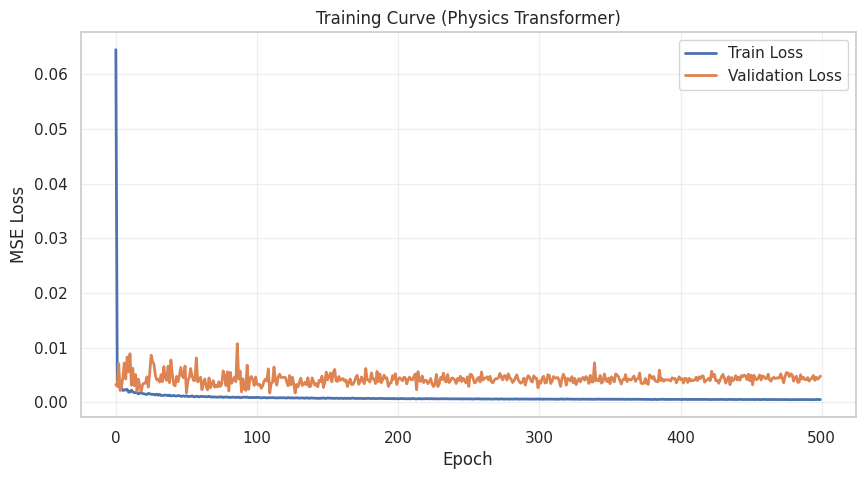


--- Sample Predictions (Val Set) ---
GT Mass    Pred Mass  | GT Mu      Pred Mu   
---------------------------------------------
1.1771     1.2776     | 0.3163     0.3114
2.3527     2.2051     | 0.4052     0.4144
0.9555     1.0378     | 0.2658     0.2749
2.2101     2.2516     | 0.2521     0.2507
0.5081     0.5257     | 0.2812     0.3039


In [53]:
import matplotlib.pyplot as plt

# ==========================================
# 4. VISUALIZATION
# ==========================================
# 1. Loss Curve
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Train Loss', linewidth=2)
plt.plot(val_losses, label='Validation Loss', linewidth=2)
plt.title('Training Curve (Physics Transformer)')
plt.xlabel('Epoch')
plt.ylabel('MSE Loss')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

# 2. Prediction Check (First 5 samples of Val Set)
model.eval()
with torch.no_grad():
    sample_acc, sample_vel, sample_y = next(iter(val_loader))
    sample_acc, sample_vel = sample_acc.to(device), sample_vel.to(device)
    preds = model(sample_acc, sample_vel).cpu()
    
    print("\n--- Sample Predictions (Val Set) ---")
    print(f"{'GT Mass':<10} {'Pred Mass':<10} | {'GT Mu':<10} {'Pred Mu':<10}")
    print("-" * 45)
    for i in range(5):
        print(f"{sample_y[i,0]:.4f}     {preds[i,0]:.4f}     | {sample_y[i,1]:.4f}     {preds[i,1]:.4f}")


STARTING COMPREHENSIVE EVALUATION
1. Calculating Metrics on Full Validation Set...
------------------------------
Mass MAE       : 0.0777
Mass R2        : 0.9877
Mu MAE         : 0.0112
Mu R2          : 0.9731
------------------------------
2. Generating Statistical Dashboard...


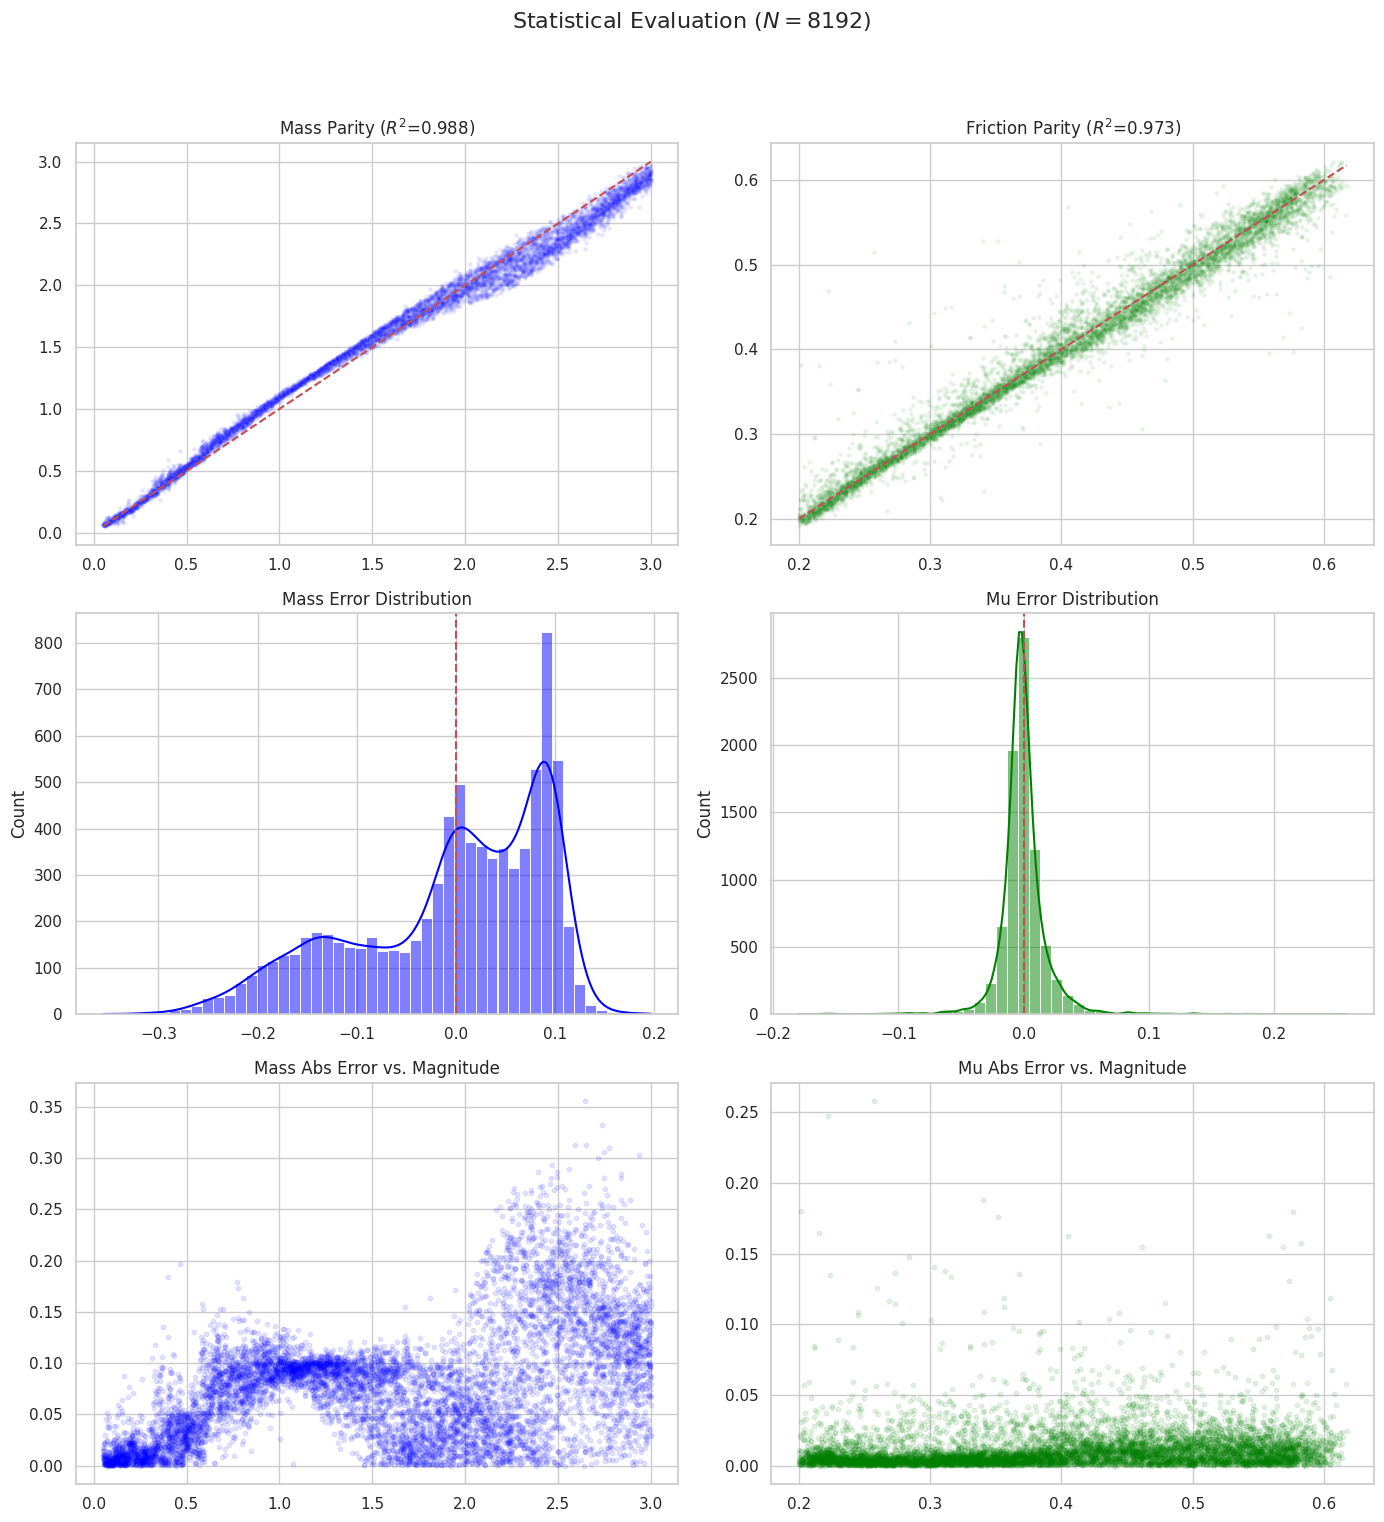

3. Visualizing Force Profile Reconstruction (Sampled)...


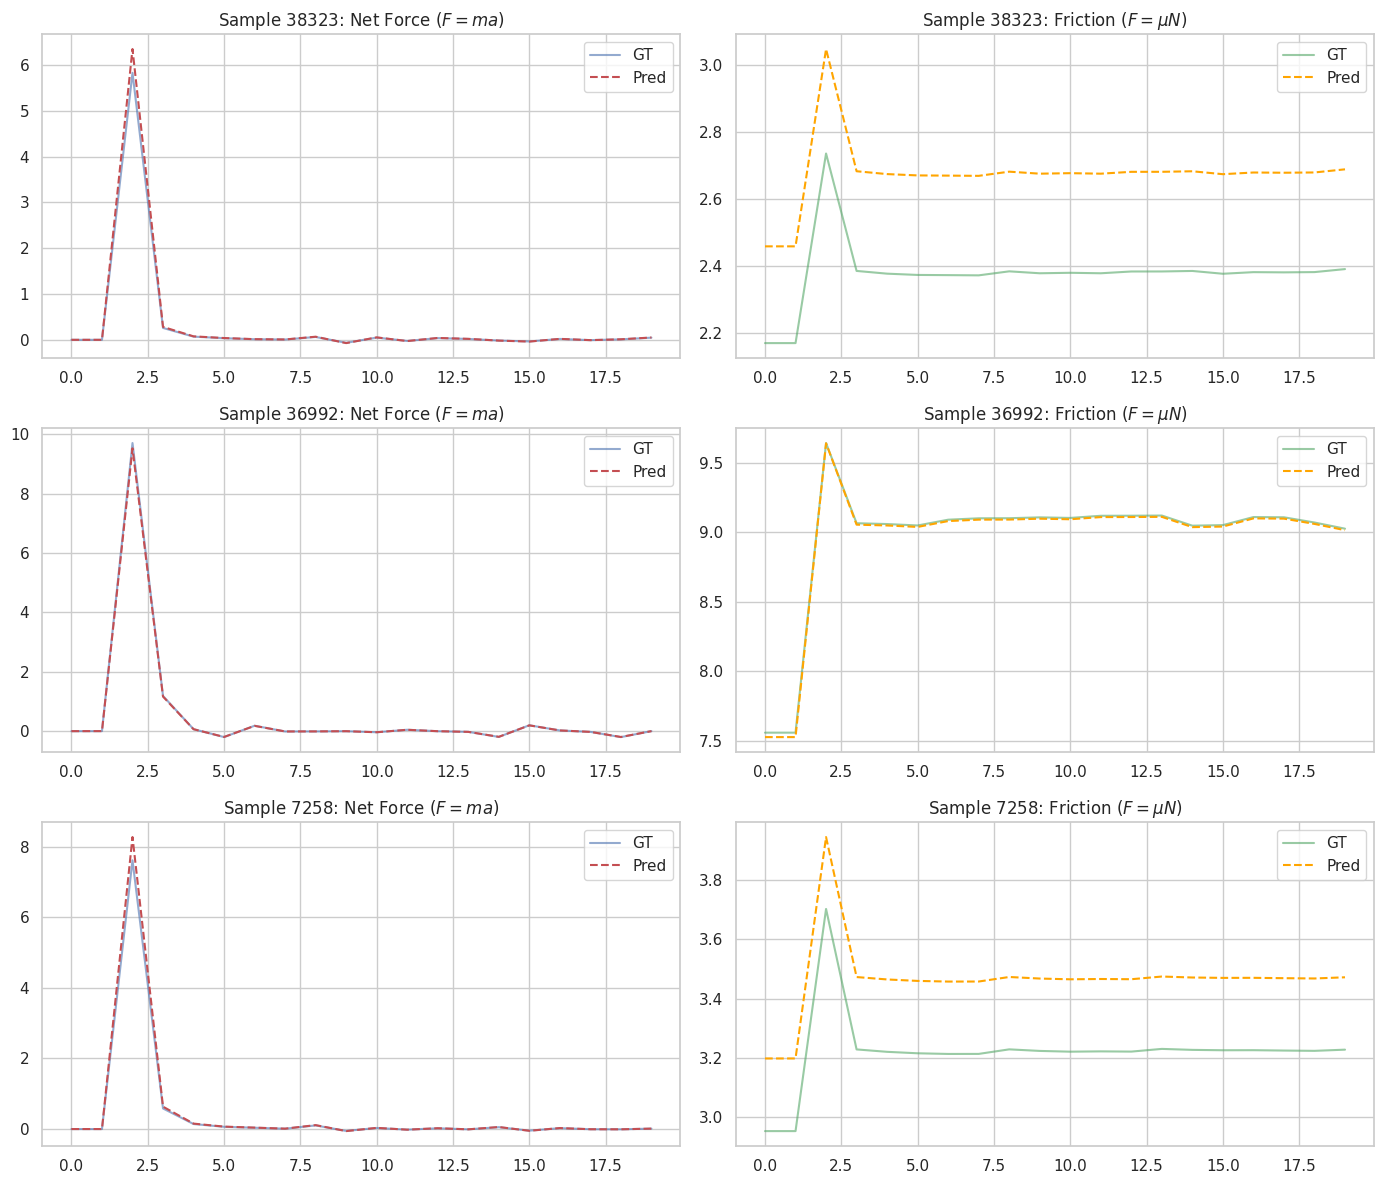

4. Visualizing Attention & Latent Spaces...


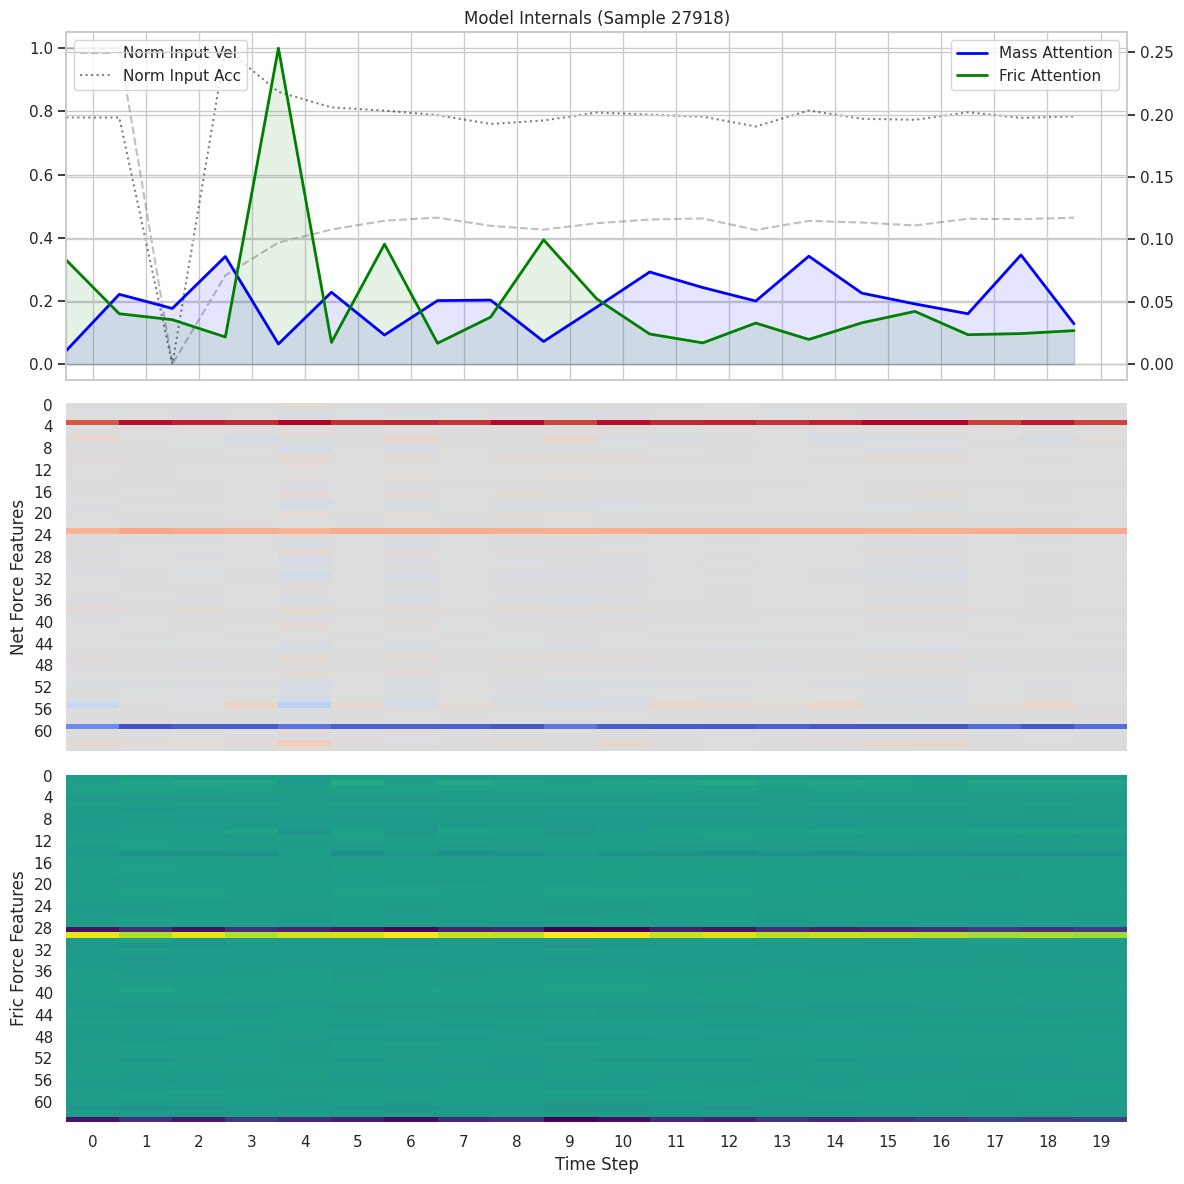

✅ Comprehensive Evaluation Complete.


In [54]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import torch
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# ==========================================
# MASTER EVALUATION CELL
# ==========================================
if 'model' in locals() and 'val_loader' in locals():
    print("\n" + "="*50)
    print("STARTING COMPREHENSIVE EVALUATION")
    print("="*50)
    
    # ---------------------------------------------------------
    # PART 1: GLOBAL METRICS (Full Validation Set)
    # ---------------------------------------------------------
    print("1. Calculating Metrics on Full Validation Set...")
    model.eval()
    all_preds = []
    all_targets = []

    with torch.no_grad():
        for b_acc, b_vel, b_y in val_loader:
            b_acc, b_vel = b_acc.to(device), b_vel.to(device)
            preds = model(b_acc, b_vel)
            all_preds.append(preds.cpu().numpy())
            all_targets.append(b_y.numpy())

    all_preds = np.vstack(all_preds)
    all_targets = np.vstack(all_targets)

    mass_gt, mass_pred = all_targets[:, 0], all_preds[:, 0]
    mu_gt, mu_pred = all_targets[:, 1], all_preds[:, 1]

    metrics = {
        "Mass MAE": mean_absolute_error(mass_gt, mass_pred),
        "Mass R2": r2_score(mass_gt, mass_pred),
        "Mu MAE": mean_absolute_error(mu_gt, mu_pred),
        "Mu R2": r2_score(mu_gt, mu_pred),
    }

    print("-" * 30)
    for k, v in metrics.items():
        print(f"{k:<15}: {v:.4f}")
    print("-" * 30)

    # ---------------------------------------------------------
    # PART 2: STATISTICAL DASHBOARD
    # ---------------------------------------------------------
    print("2. Generating Statistical Dashboard...")
    sns.set_style("whitegrid")
    fig1, axes = plt.subplots(3, 2, figsize=(14, 16))
    fig1.suptitle(f"Statistical Evaluation ($N={len(mass_gt)}$)", fontsize=16)

    # Parity Plots
    sns.scatterplot(x=mass_gt, y=mass_pred, ax=axes[0,0], alpha=0.1, color='blue', s=10)
    axes[0,0].plot([mass_gt.min(), mass_gt.max()], [mass_gt.min(), mass_gt.max()], 'r--')
    axes[0,0].set_title(f"Mass Parity ($R^2$={metrics['Mass R2']:.3f})")
    
    sns.scatterplot(x=mu_gt, y=mu_pred, ax=axes[0,1], alpha=0.1, color='green', s=10)
    axes[0,1].plot([mu_gt.min(), mu_gt.max()], [mu_gt.min(), mu_gt.max()], 'r--')
    axes[0,1].set_title(f"Friction Parity ($R^2$={metrics['Mu R2']:.3f})")

    # Residuals
    sns.histplot(mass_pred - mass_gt, kde=True, ax=axes[1,0], color='blue', bins=50)
    axes[1,0].set_title("Mass Error Distribution")
    axes[1,0].axvline(0, color='r', linestyle='--')
    
    sns.histplot(mu_pred - mu_gt, kde=True, ax=axes[1,1], color='green', bins=50)
    axes[1,1].set_title("Mu Error Distribution")
    axes[1,1].axvline(0, color='r', linestyle='--')

    # Error vs Magnitude
    axes[2,0].scatter(mass_gt, np.abs(mass_pred - mass_gt), alpha=0.1, c='blue', s=10)
    axes[2,0].set_title("Mass Abs Error vs. Magnitude")
    
    axes[2,1].scatter(mu_gt, np.abs(mu_pred - mu_gt), alpha=0.1, c='green', s=10)
    axes[2,1].set_title("Mu Abs Error vs. Magnitude")
    
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()

    # ---------------------------------------------------------
    # PART 3: FORCE PROFILE RECONSTRUCTION
    # ---------------------------------------------------------
    print("3. Visualizing Force Profile Reconstruction (Sampled)...")
    num_samples = 3
    indices = np.random.randint(0, len(df), size=num_samples)
    AXIS_MOTION, AXIS_VERTICAL, G = 3, 5, 9.81
    
    fig2, axes2 = plt.subplots(num_samples, 2, figsize=(14, 4 * num_samples))
    if num_samples == 1: axes2 = axes2.reshape(1, -1)
    
    acc_cols = [c for c in df.columns if "input_acc_" in c]
    vel_cols = [c for c in df.columns if "input_vel_" in c]
    acc_cols.sort(key=lambda x: int(x.split('_')[-1]))
    vel_cols.sort(key=lambda x: int(x.split('_')[-1]))

    for i, idx in enumerate(indices):
        row = df.iloc[idx]
        x_acc_np = row[acc_cols].values.astype(np.float32).reshape(1, 20, 1)
        x_vel_np = row[vel_cols].values.astype(np.float32).reshape(1, 20, 1)
        
        with torch.no_grad():
            preds = model(torch.tensor(x_acc_np).to(device), torch.tensor(x_vel_np).to(device)).cpu().numpy()[0]
        
        # Physics Reconstruct
        rhs_acc = get_sequence_data(row, "pinn_RHS_acc")[int(row['start_t']):int(row['start_t'])+20]
        rob_wrench = get_sequence_data(row, "pinn_robot_wrench")[int(row['start_t']):int(row['start_t'])+20]
        time_steps = np.arange(20)

        # Plot Net Force
        ax = axes2[i, 0]
        ax.plot(time_steps, row['gt_mass'] * rhs_acc[:, AXIS_MOTION], 'b-', alpha=0.6, label='GT')
        ax.plot(time_steps, preds[0] * rhs_acc[:, AXIS_MOTION], 'r--', label='Pred')
        ax.set_title(f"Sample {idx}: Net Force ($F=ma$)")
        ax.legend()
        
        # Plot Friction
        ax = axes2[i, 1]
        norm_force_gt = (row['gt_mass'] * G) - rob_wrench[:, AXIS_VERTICAL]
        norm_force_pred = (preds[0] * G) - rob_wrench[:, AXIS_VERTICAL]
        ax.plot(time_steps, row['gt_mu'] * norm_force_gt, 'g-', alpha=0.6, label='GT')
        ax.plot(time_steps, preds[1] * norm_force_pred, 'orange', linestyle='--', label='Pred')
        ax.set_title(f"Sample {idx}: Friction ($F=\mu N$)")
        ax.legend()
        
    plt.tight_layout()
    plt.show()

    # ---------------------------------------------------------
    # PART 4: EXPLAINABILITY (ATTENTION & LATENTS)
    # ---------------------------------------------------------
    print("4. Visualizing Attention & Latent Spaces...")
    
    # Setup Hooks
    activations = {}
    def get_hook(name):
        def hook(model, input, output):
            if isinstance(output, tuple): activations[name] = output[1].detach().cpu() # Attention
            else: activations[name] = output.detach().cpu() # Latent
        return hook

    hooks = [
        model.mass_attn.register_forward_hook(get_hook('mass_attn')),
        model.fric_attn.register_forward_hook(get_hook('fric_attn')),
        model.net_force_mlp.register_forward_hook(get_hook('feat_net')),
        model.fric_force_mlp.register_forward_hook(get_hook('feat_fric'))
    ]

    # Run Single Sample
    sample_idx = np.random.randint(0, len(df))
    row = df.iloc[sample_idx]
    x_acc = row[acc_cols].values.astype(np.float32).reshape(1, 20, 1)
    x_vel = row[vel_cols].values.astype(np.float32).reshape(1, 20, 1)
    
    with torch.no_grad():
        _ = model(torch.tensor(x_acc).to(device), torch.tensor(x_vel).to(device))
    
    # Remove Hooks
    for h in hooks: h.remove()

    # Normalize inputs for plotting
    def norm(d): return (d - d.min()) / (d.max() - d.min() + 1e-6)
    
    # Plotting
    fig3, axes3 = plt.subplots(3, 1, figsize=(12, 12), sharex=True)
    
    # 1. Attention Weights
    ax_att = axes3[0]
    ax_att.set_title(f"Model Internals (Sample {sample_idx})")
    ax_att.plot(norm(x_vel.flatten()), 'gray', linestyle='--', alpha=0.5, label='Norm Input Vel')
    ax_att.plot(norm(x_acc.flatten()), 'black', linestyle=':', alpha=0.5, label='Norm Input Acc')
    
    ax2 = ax_att.twinx()
    ax2.plot(activations['mass_attn'].squeeze(), 'blue', lw=2, label='Mass Attention')
    ax2.fill_between(range(20), 0, activations['mass_attn'].squeeze(), color='blue', alpha=0.1)
    ax2.plot(activations['fric_attn'].squeeze(), 'green', lw=2, label='Fric Attention')
    ax2.fill_between(range(20), 0, activations['fric_attn'].squeeze(), color='green', alpha=0.1)
    ax2.legend(loc='upper right')
    ax_att.legend(loc='upper left')
    
    # 2. Latent Heatmaps
    sns.heatmap(activations['feat_net'][0].T, ax=axes3[1], cmap="coolwarm", center=0, cbar=False)
    axes3[1].set_ylabel("Net Force Features")
    
    sns.heatmap(activations['feat_fric'][0].T, ax=axes3[2], cmap="viridis", cbar=False)
    axes3[2].set_ylabel("Fric Force Features")
    axes3[2].set_xlabel("Time Step")
    
    plt.tight_layout()
    plt.show()
    print("✅ Comprehensive Evaluation Complete.")
else:
    print("❌ Model or Data not found. Please run training cells first.")